# Introduction on how to use Euro Data Cube xcube generator service

This notebook demonstrates how to generate data cubes in `zarr` format using different data stores offered within Euro Data Cube (EDC). To run the notebook, please make sure you have a [xcube generator subscription](https://eurodatacube.com/marketplace/services/edc_xcube_generator). There is a free trial availabe, to get you started right away. 

In this notebook you will learn how to:

-  Setup your environment in order to be able to use the xcube generation service,
-  Request Sentinel Data,
-  Request data from selected Copernicus Service,
-  Request data from Copernicus Climate Data Store,
-  Request data from ESA Climate Change Initiative.



## Preparatory steps

1.	In your [Vantage's Code](https://code.vantage.earthi.world) environment, click on "New Launcher",
2.	Select "Terminal",
3.	In the Terminal, please execute (this step might take some minutes):  
```
mamba install -c conda-forge xcube=0.9.1 xcube-cci=0.9.2 xcube-cds=0.9.1 xcube-sh=0.9.2 -y
```
4.	Once it has finished downloading the new versions go back to this notebook,
5.	Restart the kernel to make sure you will get the newly installed software, using the circle arrow button on the top right corner.


## Load packages and environment variables and create service configuration

In [1]:
import getpass

In [2]:
clientID = getpass.getpass('XCUBE CLIENT ID: ')

XCUBE CLIENT ID:  ································


In [3]:
clientSecret = getpass.getpass('XCUBE CLIENT SECRET: ')

XCUBE CLIENT SECRET:  ···········································


In [4]:
import os
os.environ["XCUBE_GEN_AUTH_AUD"] = "https://xcube-gen.brockmann-consult.de/api/v2/"
os.environ["XCUBE_GEN_API_SERVER_PORT"] = "443"
os.environ["XCUBE_GEN_AUTH_DOMAIN"] = "https://xcube-users.brockmann-consult.de/api/v2"
os.environ["XCUBE_GEN_AUTH_CLIENT_ID"] = clientID
os.environ["XCUBE_GEN_AUTH_CLIENT_SECRET"] = clientSecret
os.environ["XCUBE_GEN_API_SERVER_URL"] = "https://xcube-gen.brockmann-consult.de"

os.environ["CATALOG_NAME"] = "eurodatacube"
os.environ["CATALOG_URL"] = "https://nbviewer.hub.eox.at/notebooks"
os.environ["EDC_PATH"] = "/home/jovyan/.shared/notebooks/eurodatacube"

In [5]:
from xcube.version import version

In [6]:
version

'0.9.1'

In [7]:
from xcube.core.gen2 import InputConfig
from xcube.core.gen2 import CubeConfig
from xcube.core.gen2 import OutputConfig
from xcube.core.gen2 import CubeGeneratorRequest
from xcube.core.gen2 import CubeGenerator
from xcube.core.gen2 import ServiceConfig

# utilities
import os
import xcube
import IPython.display
import shapely.geometry
%matplotlib inline

In [8]:
from edc import setup_environment_variables
setup_environment_variables()

API credentials have automatically been injected for your active subscriptions.  
The following environment variables are now available:



The manual creation of the service_config_json will not be required in future versions.

In [9]:
service_config_json = {
  "endpoint_url": os.getenv("XCUBE_GEN_API_SERVER_URL") + "/api/v2", 
  "client_id": os.getenv("XCUBE_GEN_AUTH_CLIENT_ID"), 
  "client_secret": os.getenv("XCUBE_GEN_AUTH_CLIENT_SECRET") 
}

In [10]:
service_config = ServiceConfig.from_dict(service_config_json)

## Requesting Sentinel Data

Before we start, the area of interest needs to be defined. Let's take a look at northern Germany:

In [11]:
x1 = 7.  # degree
y1 = 53  # degree
x2 = 11  # degree
y2 = 55  # degree

bbox = x1, y1, x2, y2

Let's check the region, to make sure it covers the expected area:

In [12]:
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

Please check the table for available Sentinel Data and if you would like to get more information about a particular sensor or band head over to the documentation of the data sets: https://docs.sentinel-hub.com/api/latest/data/

 | Dataset     | Variables               | Data ID |Store ID     | 
| -------- | -------- |----|----|
| `Sentinel-1 GRD`       | `VV`, `VH`, `HV`, `HH` | `S1GRD`| `@sentinelhub_eu` |
| `Sentinel-2 MSI L1C`   | `B01`, `B02`, `B03`, `B04`, `B05`, `B06`, `B07`, `B08`, `B8A`, `B09`, `B10`, `B11`, `B12` | `S2L1C`| `@sentinelhub_eu` |
| `Sentinel-2 MSI L2A`   | `B01`, `B02`, `B03`, `B04`, `B05`, `B06`, `B07`, `B08`, `B8A`, `B09`, `B10`, `B11`, `B12` | `S2L2A`| `@sentinelhub_eu` |
| `Sentinel-3 OCLI L1B`  | `B01`, `B02`, `B03`, `B04`, `B05`, `B06`, `B07`, `B08`, `B09`, `B10`, `B11`, `B12`, `B13`, `B14`, `B15`, `B16`, `B17`, `B18`, `B19`, `B20`, `B21` | `S3OLCI`| `@sentinelhub_creodias` |


In the following example we will request a cube for  `Sentinel-2 MSI L2A` with the `"data_id": "S2L2A"`.    
  
Now let's create a request for the xcube generator. JSON is used here, because it could be loaded in this form from a file as well.   

A request consists of three parts: **input_config**, **cube_config** and **output_config**. 

**input_config**: Defines the source of input data as well as the particular dataset identifier `data_id`.   
**cube_config**: This is where the cube is configured. Include all information like desired variables, bounding box `bbox` or time range.   
**output_config**: Details of the target destination of the cube. The example configuration includes a public-read bucket which holds data for **4 days only**. If you use this configuration and you want to keep your data, please make sure to give a unique data_id for your cube name, because anybody can set the parameter "replace" to true and (accidentally) overwrite your cube within the eurodatacube-scratch bucket if it happens to have the exact same data_id!

If you wish to save the data into your own bucket please use the following output_config:

    "output_config": {
    "store_id": "s3",
    "data_id": "name_your_cube.zarr",
    "replace": True,
    "store_params": {
      "bucket_name": "name_of_your_aws_s3_bucket", 
      "aws_access_key_id": "AWS_ACCESS_KEY",
      "aws_secret_access_key": "AWS_SECRET"
    }


In [13]:
input_config = InputConfig(
    store_id="@sentinelhub_eu",
    data_id="S2L2A",
)

cube_config = CubeConfig(
   variable_names=["B04", "B05"],
   tile_size=[512, 512],
   spatial_res=0.001,           
   bbox = bbox,      
   time_range=["2021-03-01", "2021-03-06"]
)

output_config = OutputConfig(
    store_id="@eurodatacube_scratch",
    replace=True,
    data_id="SH_demo_v9_AB.zarr"
)

In [14]:
request = CubeGeneratorRequest(
    input_config=input_config,
    cube_config=cube_config,
    output_config=output_config
)

In [15]:
generator_service = CubeGenerator.new(service_config=service_config, verbosity=1)

To inspect the costs of the configured cube you can do it with the following lines. In the cube_info you will see, that the requested cube has an estimated cost of 384 processing units and the limit is set to 10000. The available processing units will depend on your subscription plan and whether you have already generated cubes or not. 

In [16]:
generator_service.get_cube_info(request)

<xcube.core.gen2.response.make_cube_generator_result_class.<locals>.SpecificCubeGeneratorResult at 0x7f7e21669d60>

Let's go ahead, and generate the cube. Note that depending on the cube's size this may take up to several minutes. Once it is generated the `data_id` you assinged in the `output_config` of your request will be returned. In case the cube request is missing a `data_id` a generated name will be returned.

In [17]:
from xcube.core.gen2 import CubeGeneratorError

result = generator_service.generate_cube(request)

Generating cube - ...
Generating cube - done.


In [18]:
result.result.data_id

'SH_demo_v9_AB.zarr'

To see, which cubes are available in a certain bucket, you can configure a store to show them. Here we use the `eurodatacube-scratch` bucket - so you will see all the cubes that have been placed in this bucket. **Keep in mind**: The content of `eurodatacube-scratch` is only available for **4 days** starting at the creation-moment! If you want to see the content of your own bucket, change the bucket name and in case it is not public-read you need to pass the credentials `client_kwargs = {"aws_access_key_id":"ACCESS_ID", "aws_secret_access_key":"SECRET_KEY"}`. In case you use your own private bucket you need to configure the new_data_store like this: `xcube_store = new_data_store("s3", bucket_name="eurodatacube-scratch", **client_kwargs)`

In [19]:
# Code fragment example to use a custom bucket
#client_kwargs = {"aws_access_key_id":"ACCESS_ID", "aws_secret_access_key":"SECRET_KEY"}
#xcube_store = new_data_store("s3", bucket_name="YOUR-BUCKET-NAME", **client_kwargs)

In [20]:
from xcube.core.store import new_data_store
xcube_store = new_data_store("s3", root="eurodatacube-scratch", storage_options=dict(anon=True))

In [21]:
dataset_id_list = list(xcube_store.get_data_ids())

In [22]:
dataset_id_list

['SH_demo_v9_AB.zarr']

Let's checkout the cube we just created:

In [23]:
ds = xcube_store.open_data(dataset_id_list[0])
ds

<xarray.Dataset>
Dimensions:    (time: 4, lat: 2048, lon: 4096, bnds: 2)
Coordinates:
  * lat        (lat) float64 55.05 55.05 55.05 55.04 ... 53.0 53.0 53.0 53.0
  * lon        (lon) float64 7.0 7.002 7.002 7.003 ... 11.09 11.09 11.09 11.1
  * time       (time) datetime64[ns] 2021-03-01T10:55:53 ... 2021-03-05T10:35:56
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(4, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
Attributes: (12/18)
    Conventions:                CF-1.7
    date_created:               2021-12-07T13:32:02.090753
    geospatial_bounds:          POLYGON((7 53, 7 55.048, 11.096 55.048, 11.09...
    geospatial_bounds_crs:      CRS84
    geospatial_lat_max:         55.048
    geospatial_lat_min:         53
    ...                         ...
    history:                    [{'cube_config': {'band_fill_values': None, '...
    processing_level:           L2A
    time_coverage_duration:     P3DT23H40M56S
    time_coverage_end:          2021-03-05T10:36:25+00:00
    time_coverage_start:        2021-03-01T10:55:29+00:00
    title:                      S2L2A Data Cube Subset

Now, let's take a look at the plot of the data:

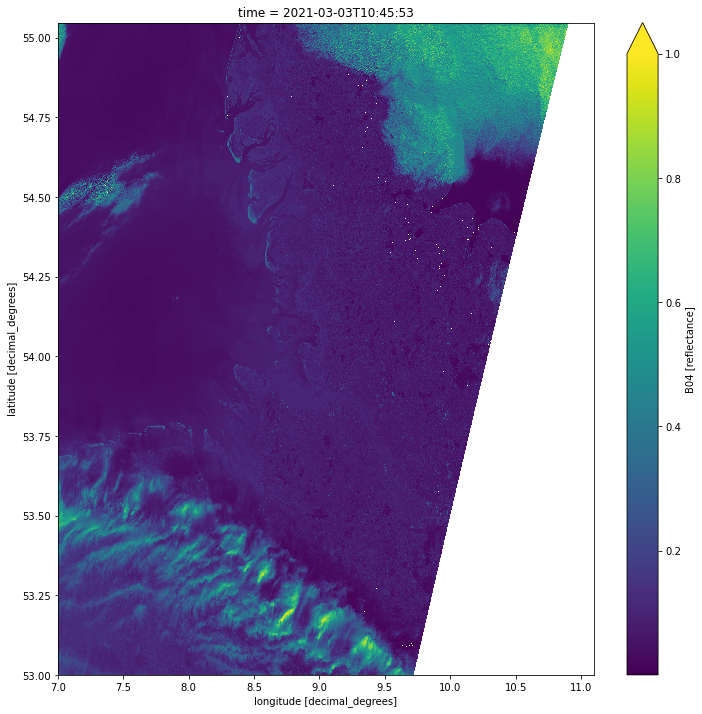

In [24]:
ds.B04.isel(time=2).plot(figsize=[12,12], vmax=1.0)